I- PREPROCESSING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

import sklearn.linear_model as s_lm
import sklearn.feature_selection as s_fs
import sklearn.preprocessing as s_pp
regres = s_lm.LinearRegression()
scaler = s_pp.StandardScaler()

II- IMPORT DATA AND ANALYSE

In [2]:
celRawData = pd.read_csv('celData.csv')
descRawData = celRawData.describe(include="all")
print(descRawData)
#print(celRawData)

          MARCA    MODELO        RAM          HDD  Expansivo  Freq. Core  \
count        62        62  62.000000    62.000000  62.000000   62.000000   
unique       10        62        NaN          NaN        NaN         NaN   
top     SAMSUNG  Moto E13        NaN          NaN        NaN         NaN   
freq         16         1        NaN          NaN        NaN         NaN   
mean        NaN       NaN   5.532258   154.322581   0.709677    2.061290   
std         NaN       NaN   2.140306   132.577076   0.457617    0.238406   
min         NaN       NaN   1.000000    32.000000   0.000000    1.400000   
25%         NaN       NaN   4.000000   128.000000   0.000000    1.900000   
50%         NaN       NaN   6.000000   128.000000   1.000000    2.100000   
75%         NaN       NaN   8.000000   128.000000   1.000000    2.200000   
max         NaN       NaN  12.000000  1024.000000   1.000000    2.600000   

               5G      DOWNLOAD       UPLOAD TELA        Ver      Princ.  \
count   62.

III- CLEAN DATA

0- Dividir o RAW em dois, a tabela das variaveis independentes(xi) e a tabela da variavel dependente(y=PREÇO DE CALCULO) 
1- Percebe-se que faltam alguns valores em DOWNLOAD, UPLOAD e ANGULO MAXIMO.
-DOWNLOAD E UPLOAD: perceba que são função relacionados com a conectividade 5G. Para completar os dados que estão faltando, fazemos uma média entre os que possuem 5G e colocamos a media nos valores faltantes. Faz-se o mesmo para os que não possuem 5G.
Vale ressaltar que há em DOWNLOADS dois valores extremos de 10000mbps que irão alterar a media e precisam ser retirados.
-ANGULO MÁXIMO: como não há nenhuma relação direta, tira-se a media para completar os valores faltantes
2- MODELO E MARCA: Perceba que modelo é muito variavel, de modo que não há sentido em coloca-lo no modelo. Marca deve ser verificado para caso ela tenha peso no preço.

In [3]:
#CRIAÇÃO DAS TABELAS A SEREM MANIPULADAS
auxData = celRawData

#TABELAS PARA AJUSTE
downData = auxData[['5G','DOWNLOAD']]
upData = auxData[['5G','UPLOAD']]
angData = auxData['Angulo Maximo']

down5G = downData.loc[downData['5G']==1]
down4G = downData.loc[downData['5G']==0]

up5G = upData.loc[upData['5G']==1]
up4G = upData.loc[upData['5G']==0]

#ACRESCIMO DA MEDIA
down5G.fillna(down5G.mean(), inplace=True)
down4G.fillna(down4G.mean(), inplace=True)
up5G.fillna(up5G.mean(), inplace=True)
up4G.fillna(up4G.mean(), inplace=True)
angData.fillna(angData.mean(), inplace=True)

for i in down5G.index:
    downData['DOWNLOAD'].loc[i]= down5G['DOWNLOAD'].loc[i]
for i in down4G.index:
    downData['DOWNLOAD'].loc[i]= down4G['DOWNLOAD'].loc[i]

for i in up5G.index:
    upData['UPLOAD'].loc[i]= up5G['UPLOAD'].loc[i]
for i in up4G.index:
    upData['UPLOAD'].loc[i]= up4G['UPLOAD'].loc[i]

#CORREÇÃO NA TABELA PRINCIPAL
auxData['DOWNLOAD'] = downData['DOWNLOAD']
auxData['UPLOAD'] = upData['UPLOAD']
auxData['Angulo Maximo'] = angData

#auxData.drop(columns=["MODELO"],inplace=True)
#print(auxData)

/tmp/ipykernel_6056/3963802914.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down5G.fillna(down5G.mean(), inplace=True)
/tmp/ipykernel_6056/3963802914.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down5G.fillna(down5G.mean(), inplace=True)
/tmp/ipykernel_6056/3963802914.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

IV- INICIO DA ANÁLISE

0- Remover valores extremos
1- Checkar visualmente pelo distplot variaveis pouco relacionadas e as retirar
2- Criar os dummies
3- Normalizar todas as variaveis do modelo
4- Criacao da REGRESSAO

In [4]:
#REMOVENDO OS VALORES EXTREMOS DE DOWNLOAD
Q = auxData['DOWNLOAD'].quantile(.99)
auxData_1 = auxData[auxData['DOWNLOAD']<Q]

#REMOVENDO OS VALORES MINIMOS DE RAM
Q = auxData_1['RAM'].quantile(.01)
auxData_2 = auxData_1[auxData_1['RAM']>Q]

#REMOVER VARIAVEIS INUTEIS
#RETIRAR: ,'Ver','Angulo Maximo','BATERIA','Expansivo','Bússola'
#RETIRAR:,'MARCA','TELA','5G','UPLOAD'
#RETIRAR:,'RAM', 'Freq. Atual.','Giroscópio'
cleanData = auxData_2.drop(columns=['MODELO']).reset_index(drop=True)


#DUMMIES
cleanDummys = pd.get_dummies(cleanData, drop_first=True)


In [5]:
#STARDARDZAR
preco = cleanDummys['PREÇO DE CALCULO']
varInd = cleanDummys.drop(columns=['PREÇO DE CALCULO'])

scaler.fit(varInd)
scaledVar = scaler.transform(varInd)

In [6]:
#REGRESSAO
regres.fit(scaledVar,preco)

'''
print(regres.score(scaledVar,preco))
print(regres.coef_)
print(regres.intercept_)
print(regres.predict(scaledVar))
'''
DELTA = pd.DataFrame()
DELTA = regres.predict(scaledVar) - preco
previsao = pd.DataFrame()
auxData_3 = auxData_2.reset_index(drop=True)
previsao['MODELO'] = auxData_3['MODELO']

previsao['PREVISAO'] = regres.predict(scaledVar)
previsao['PREÇO MERCADO'] = preco
previsao['PREVISAO-PREÇO'] = DELTA
previsao['(PREVISAO-PREÇO)%'] = np.abs(DELTA/preco)
print(previsao.round(2).sort_values(by='PREVISAO-PREÇO'))

                  MODELO  PREVISAO  PREÇO MERCADO  PREVISAO-PREÇO  \
26            Reno 6 PRO   3965.71        4902.02         -936.31   
53            Xiaomi 12t   2655.50        3311.50         -656.00   
10            Galaxy M23   2167.76        2731.00         -563.24   
15         Galaxy A24 4G   1020.09        1554.00         -533.91   
46     RedMi 11 PRIME 5G    762.33        1284.00         -521.67   
16            Galaxy A31    982.54        1469.00         -486.46   
30             Poco  C55   1005.50        1459.00         -453.50   
19            Galaxy A53   1927.07        2374.00         -446.93   
28            Reno 8 PRO   3593.22        4001.81         -408.59   
42             RealMe 9I    977.71        1315.00         -337.29   
25                   A77   1417.96        1749.14         -331.19   
51  RedMi Note 12 PRO 4G   1485.79        1789.33         -303.54   
14            Galaxy A14   1262.31        1554.00         -291.69   
33            Poco X4 GT   2859.08

V- VALIDAÇÃO DAS VARIAVEIS

In [7]:
#R² e adjR²
def adj_r2(r2,n,p):
    return 1-(1-r2)*(n-1)/(n-p-1)
r2 = regres.score(scaledVar,preco)
n = len(preco.index)
p = len(varInd.columns)

adjR2 = adj_r2(r2,n,p)
print(f'Numero de observações: {n}\nNumero de predicadores: {p}\nO valor de R²: {r2}\nO valor de adjusR²:{adjR2}\n\n')

#VARIAVEIS E SUAS INFLUENCIAS
var = pd.DataFrame(data=scaledVar,columns=varInd.columns.values)
descVar = var.describe(include='all')

p_values = s_fs.f_regression(scaledVar,preco)[1]

descVar.loc['COEFICIENTES'] = regres.coef_
descVar.loc['RELEVANCIA'] = p_values
print(descVar.loc[['COEFICIENTES','RELEVANCIA']].round(3))

Numero de observações: 57
Numero de predicadores: 26
O valor de R²: 0.8442818792555492
O valor de adjusR²:0.7093261746103585


                  RAM    HDD  Expansivo  Freq. Core     5G  DOWNLOAD  UPLOAD  \
COEFICIENTES  338.655  4.080   -227.963     -11.305  25.08    12.824  96.089   
RELEVANCIA      0.000  0.001      0.000       0.000   0.00     0.000   0.001   

                 Ver  Princ.   Front  ...  MARCA_MOTOROLA  MARCA_OPPO  \
COEFICIENTES  190.19 -35.021  67.755  ...          64.097     333.205   
RELEVANCIA      0.00   0.002   0.000  ...           0.033       0.025   

              MARCA_POCO  MARCA_REALME  MARCA_SAMSUNG  MARCA_XIAOMI  TELA_IPS  \
COEFICIENTES     124.621        73.579         89.901        83.123     7.839   
RELEVANCIA         0.561         0.365          0.674         0.714     0.001   

              TELA_OLED  TELA_PLS  TELA_TFT  
COEFICIENTES     39.361   157.943   -42.238  
RELEVANCIA        0.419     0.827     0.296  

[2 rows x 26 columns]


VARIAVEIS:
POSITIVAS
-DOWNLOAD: Essa variavel representa a existencia da tecnologia 5G, podemos ver que ela é a que mais influencia no preço
-HDD: Essa variavel descreve o espaço de memoria do celular, vemos que é a segunda com maior influencia.
-Camera Principal: Terceira que mais influencia, mas ja possui uma relevancia duvidosa

NEGATIVAS
-GIROSCOPIO: Vemos que a ausencia do Giroscopio encarece o preço
-RAM: Supreendentemente, quanto mais ram, mais barato
-Freq. Atual: Essa variavel tambem baixa o preço

VI- INTERPRETAÇÃO

          PREVISAO  PREÇO MERCADO  PREVISAO-PREÇO  (PREVISAO-PREÇO)%
count    57.000000      57.000000    5.700000e+01       5.700000e+01
mean   1723.983465    1723.983465    1.475934e-13       1.829572e-01
std     828.054000     901.187014    3.556186e+02       1.680065e-01
min     549.732709     622.000000   -9.363095e+02       1.586144e-16
25%    1020.086202    1090.666667   -2.696704e+02       7.507979e-02
50%    1509.998375    1459.000000    2.387424e-12       1.396204e-01
75%    2222.243033    2235.666667    2.536058e+02       2.206939e-01
max    3965.710463    4902.020000    8.839148e+02       8.839148e-01


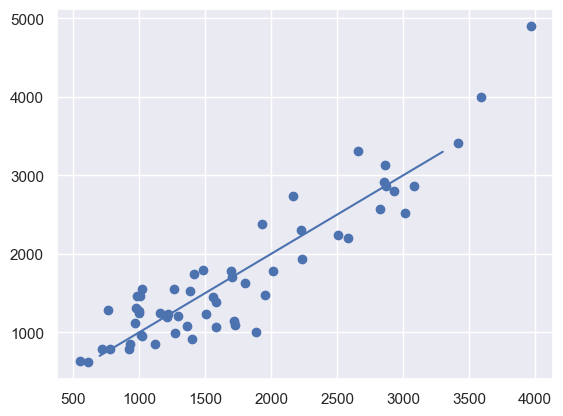

In [8]:
#DESCRICAO
print(previsao.describe())

#PLOT
x=[700,3300]
plt.scatter(previsao['PREVISAO'],previsao['PREÇO MERCADO'])
plt.plot(x,x)
plt.show()

VII- ESCOLHA

In [9]:
lmin=1100
lmax=1500
below = previsao[previsao['PREÇO MERCADO']<lmax]
between = below[below['PREÇO MERCADO']>lmin]
print(f'Limite Maximo: R${lmax}\nLimite Minimo: R${lmin}\n\n')
print(between.round(2).sort_values(by='PREVISAO-PREÇO'))


Limite Maximo: R$1500
Limite Minimo: R$1100


               MODELO  PREVISAO  PREÇO MERCADO  PREVISAO-PREÇO  \
46  RedMi 11 PRIME 5G    762.33        1284.00         -521.67   
16         Galaxy A31    982.54        1469.00         -486.46   
30          Poco  C55   1005.50        1459.00         -453.50   
42          RealMe 9I    977.71        1315.00         -337.29   
47           RedMi 12   1002.03        1271.70         -269.67   
31            Poco M3    995.16        1242.00         -246.84   
32            Poco M5    971.04        1123.42         -152.38   
6            Moto G53   1155.99        1244.78          -88.79   
4            Moto G41   1218.62        1236.22          -17.60   
5            Moto G52   1207.85        1190.25           17.60   
41         RealMe C55   1297.39        1202.42           94.97   
24                A57   1560.63        1453.98          106.65   
23                A54   1583.68        1389.66          194.02   
49      RedMi Note 9t   1510.0

VIII- FUNÇÃO

In [10]:
def tabela(base,lista):
    no_MODELO = base.drop(columns=['MODELO']).reset_index(drop=True)
    dataAux = no_MODELO.drop(columns=lista)
    dummysAux = pd.get_dummies(dataAux, drop_first=True)

    #STANDARDZATION
    precoAux = dummysAux['PREÇO DE CALCULO']
    varIndAux = dummysAux.drop(columns=['PREÇO DE CALCULO'])

    scaler.fit(varIndAux)
    scaledAux = scaler.transform(varIndAux)

    #REGRESSAO
    regres.fit(scaledAux,precoAux)

    DELT = pd.DataFrame()
    DELT = regres.predict(scaledAux) - precoAux
    previAux = pd.DataFrame()
    auxData_4 = auxData_2.reset_index(drop=True)
    previAux['MODELO'] = auxData_4['MODELO']

    previAux['PREVISAO'] = regres.predict(scaledAux)
    previAux['PREÇO MERCADO'] = precoAux
    previAux['PREVISAO-PREÇO'] = DELT
    previAux['(PREVISAO-PREÇO)%'] = np.abs(DELT/precoAux)


    #R² e adjR²
    r2Aux = regres.score(scaledAux,precoAux)
    nAux = len(precoAux.index)
    pAux = len(varIndAux.columns)

    adjR2Aux = adj_r2(r2Aux,nAux,pAux)


    #VARIAVEIS E SUAS INFLUENCIAS
    varAux = pd.DataFrame(data=scaledAux,columns=varIndAux.columns.values)
    descVarAux = varAux.describe(include='all')

    p_valuesAux = s_fs.f_regression(scaledAux,precoAux)[1]

    descVarAux.loc['COEFICIENTES'] = regres.coef_
    descVarAux.loc['RELEVANCIA'] = p_valuesAux



    #PRINTS
    print(f'Numero de observações: {nAux}\nNumero de predicadores: {pAux}\nO valor de R²: {r2Aux}\nO valor de adjusR²:{adjR2Aux}')
    print('\n\nTabela dos coeficientes e suas relevancias:\n')
    print(descVarAux.loc[['COEFICIENTES','RELEVANCIA']].round(3))
    print('\n')
    print(f'\n\nTabela descritiva:\n{previAux.describe()}')

    #DEBUG TODOS OS PREDICATORIOS
    '''for i in descVarAux.columns:
        print(i)
        print(descVarAux[i].loc[['COEFICIENTES','RELEVANCIA']].round(3))
        print('\n')'''

    #PLOT
    x=[700,3300]
    plt.scatter(previAux['PREVISAO'],previAux['PREÇO MERCADO'])
    plt.plot(x,x)
    plt.show()

    print('\n\nTabela sem limitações:\n')
    print(previAux.sort_values(by='PREVISAO-PREÇO').round(2))

    belowAux = previAux[previsao['PREÇO MERCADO']<lmax]
    betweenAux = belowAux[belowAux['PREÇO MERCADO']>lmin]
    print(f'\n\nLimite Maximo: R${lmax}\nLimite Minimo: R${lmin}\n\n')
    print(betweenAux.round(2).sort_values(by='PREVISAO-PREÇO'))


Numero de observações: 57
Numero de predicadores: 19
O valor de R²: 0.8146008942720386
O valor de adjusR²:0.7193959480874098


Tabela dos coeficientes e suas relevancias:

                  RAM     HDD  Expansivo  Freq. Core       5G   Princ.  \
COEFICIENTES  371.105 -46.718   -241.968       4.972  102.509 -128.989   
RELEVANCIA      0.000   0.001      0.000       0.000    0.000    0.002   

                Front  MARCA_BLACKVIEW  MARCA_DOOGEE  MARCA_MOTOROLA  \
COEFICIENTES  194.881           -7.380       157.927         -50.507   
RELEVANCIA      0.000            0.979         0.057           0.033   

              MARCA_OPPO  MARCA_POCO  MARCA_REALME  MARCA_SAMSUNG  \
COEFICIENTES     133.859      12.604       -82.422       -246.754   
RELEVANCIA         0.025       0.561         0.365          0.674   

              MARCA_XIAOMI  TELA_IPS  TELA_OLED  TELA_PLS  TELA_TFT  
COEFICIENTES        -2.592  -148.749    -16.356   144.417     3.186  
RELEVANCIA           0.714     0.001    

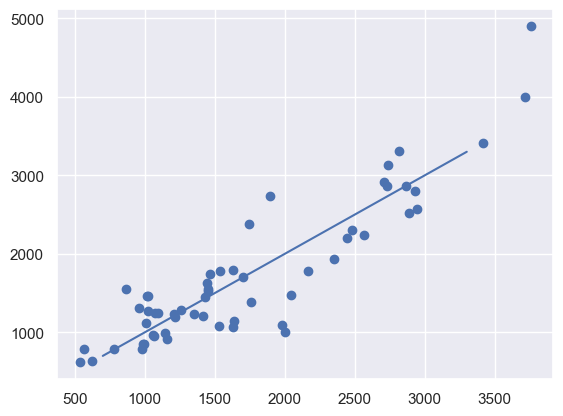



Tabela sem limitações:

                  MODELO  PREVISAO  PREÇO MERCADO  PREVISAO-PREÇO  \
26            Reno 6 PRO   3756.24        4902.02        -1145.78   
10            Galaxy M23   1893.03        2731.00         -837.97   
15         Galaxy A24 4G    867.03        1554.00         -686.97   
19            Galaxy A53   1744.97        2374.00         -629.03   
53            Xiaomi 12t   2818.37        3311.50         -493.13   
16            Galaxy A31   1016.89        1469.00         -452.11   
30             Poco  C55   1023.71        1459.00         -435.29   
33            Poco X4 GT   2734.65        3137.67         -403.01   
42             RealMe 9I    957.64        1315.00         -357.36   
28            Reno 8 PRO   3716.63        4001.81         -285.18   
25                   A77   1465.81        1749.14         -283.34   
47              RedMi 12   1023.79        1271.70         -247.91   
7               Moto G60   1536.18        1782.00         -245.82   
39      

In [11]:
lista = ['Ver','Angulo Maximo','BATERIA','Bússola','DOWNLOAD','UPLOAD','Giroscópio']
tabela(auxData_2,lista)